This notebook gathers results from running top-pruning nni-searches on the ds-datasets and flu100.

To benchmark against existing methods, we compare with the topologies discovered by a short run of Mr Bayes and match the data by approximate run-time. For run-time, scripts ran on the slurm cluster as jobs with exclusive node access, with the calculations turned off for collecting the other statistics. 

In [1]:
%%javascript
 
// I dislike the default Jupyter notebook scrolling.
Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('up');
Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('down');

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)

In [3]:
# Load all data files into dataframes.
ds_datasets = [1, 3, 4, 5, 6, 7, 8]
mb_prior = {"uniform":"_output"}
search_type = {"top-pruning": "tp"}
iter_count = {1:1000,3:1000,4:2000,5:2000,6:2000,7:1000,8:2000}

#Time spent by MrBayes.
mb_avg_gen_run_time = {
    (1, "uniform"): 434/1000000,
    (3, "uniform"): 652/1000000,
    (4, "uniform"): 456/1000000,
    (5, "uniform"): 254/1000000,
    (6, "uniform"): 367/1000000,
    (7, "uniform"): 874/1000000,
    (8, "uniform"): 377/1000000
}

#Time spent processing trees from MrBayes before building sDAGs.
processing_mb_avg_gen_run_time = {
    (1, "uniform"): 37/1000000,
    (3, "uniform"): 49/1000000,
    (4, "uniform"): 54/1000000,
    (5, "uniform"): 67/1000000,
    (6, "uniform"): 67/1000000,
    (7, "uniform"): 79/1000000,
    (8, "uniform"): 82/1000000
}

search_results_path = "data/ds{}/{}/ds{}.results.{}.{}.csv"
short_mcmc_stats_path = "data/ds{}/{}/short_mcmc/mcmc_search_sdag_stats.csv"
#short_mcmc_sdag_time_path = "data/ds{}/{}/short_mcmc/mcmc_search_sdag_stats.time.csv"
#Can probably skip the above file, since now timing is included by default.

search_time_path = search_results_path[:-4] + ".time.csv"

posterior_edge_stats_df = pd.read_csv("data/posterior_edge_counts.csv")
posterior_edge_stats_dict = posterior_edge_stats_df.set_index(["ds", "prior"]).to_dict("index")
posterior_subsplit_stats_df = pd.read_csv("data/posterior_subsplit_counts.csv")
posterior_subsplit_stats_dict = posterior_subsplit_stats_df.set_index(["ds", "prior"]).to_dict("index")

ds_search_results_dataframes = {}
ds_short_mcmc_dataframes = {}
for ds in ds_datasets:
    for prior, prior_path in mb_prior.items():
        for search, search_path in search_type.items():
            results_path = search_results_path.format(
                ds, prior_path, ds, search_path, iter_count[ds]
            )
            results_df = pd.read_csv(results_path)
            results_df.drop_duplicates(subset="iter", keep="first", inplace=True)

            time_path = search_time_path.format(
                ds, prior_path, ds, search_path, iter_count[ds]
            )
            time_df = pd.read_csv(time_path)
            results_df = results_df.merge(time_df, on="iter")

            ds_search_results_dataframes[(ds, prior, search)] = results_df
        short_mcmc_path = short_mcmc_stats_path.format(ds,prior_path)
        short_mcmc_df = pd.read_csv(short_mcmc_path)
        short_mcmc_df["time"] = mb_avg_gen_run_time[(ds,prior)]*short_mcmc_df.mcmc_iters              
        iter_time = mb_avg_gen_run_time[(ds,prior)] + processing_mb_avg_gen_run_time[(ds,prior)]
        short_mcmc_df["sdag_total_time"] = short_mcmc_df.sdag_build_time + iter_time*short_mcmc_df.mcmc_iters        
        ds_short_mcmc_dataframes[(ds, prior)] = short_mcmc_df
        
tp_multiple_start_dfs = {
    (ds, count): pd.read_csv(f"data/ds{ds}/_output/multiple_starts/ds{ds}.results.tp.300.top{count}.csv")    
    for ds in [1, 3, 4, 5, 6, 7, 8]
    for count in range(1,11)
}
tp_raxml_start_dfs = {
    ds: pd.read_csv(f"data/ds{ds}/_output/multiple_starts/ds{ds}.results.tp.300.top_raxml.csv")    
    for ds in [1, 3, 4, 5, 6, 7, 8]
}

# Finalized plots

In [4]:
def article_plot_multiple_and_raxml_trees_comparison():      
    ds_list = [1, 3, 4, 5, 6, 7, 8]
    fig, axes = plt.subplots(nrows=4, ncols=2)
    fig.set_figwidth(2*fig.get_figwidth())
    fig.set_figheight(4*fig.get_figheight())
    legend_axes = axes[0][1]
    axes = [axes[i][j] for i in range(4) for j in range(2) if (i,j)!=(0,1) ]

    for ds, ax in zip(ds_list, axes):
        single_tree_start = tp_multiple_start_dfs[(ds, 1)]
        multiple_tree_start = tp_multiple_start_dfs[(ds, 10)]
        raxml_trees_start = tp_raxml_start_dfs[ds]
        ax.plot(single_tree_start.iter, single_tree_start.tree_pp)
        ax.plot(multiple_tree_start.iter, multiple_tree_start.tree_pp)    
        ax.plot(raxml_trees_start.iter, raxml_trees_start.tree_pp)
        if ds==1:
            ax.set_xlabel("top pruning iteration", fontsize=14)
            ax.set_ylabel("cumulative density of trees\n in search sDAG", fontsize=14)
        ax.set_title(f"top pruning on DS{ds} w/ multiple starting trees", fontsize=16)
        ax.tick_params(labelsize=14)
        ax.set_ylim(bottom=0.0,top=1.05)
    
    legend_axes.axis("off")
    legend_axes.plot([0], [0], label="single starting tree")
    legend_axes.plot([0], [0], label=f"top 10 credible starting trees")
    legend_axes.plot([0], [0], label=f"raxml starting trees")        
    legend_axes.legend(loc="center left", fontsize=16)
    fig.tight_layout()
    plt.show()

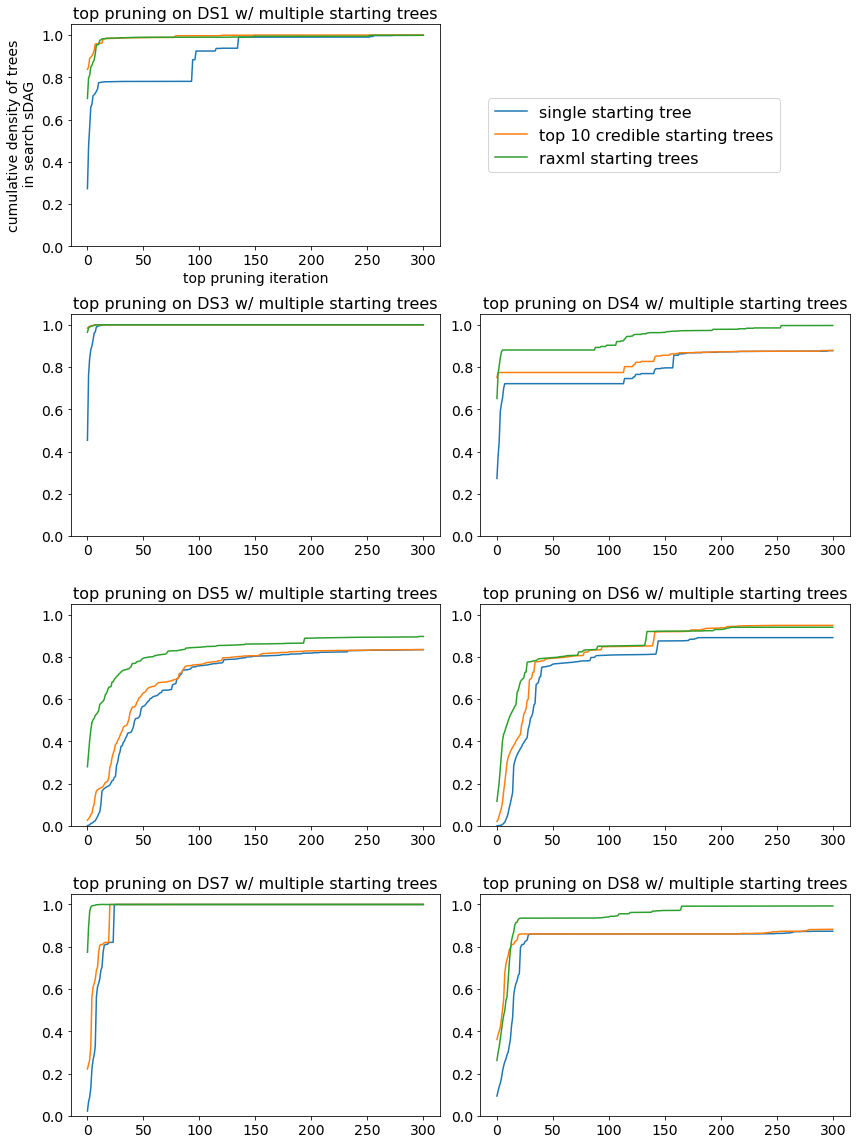

In [5]:
article_plot_multiple_and_raxml_trees_comparison()

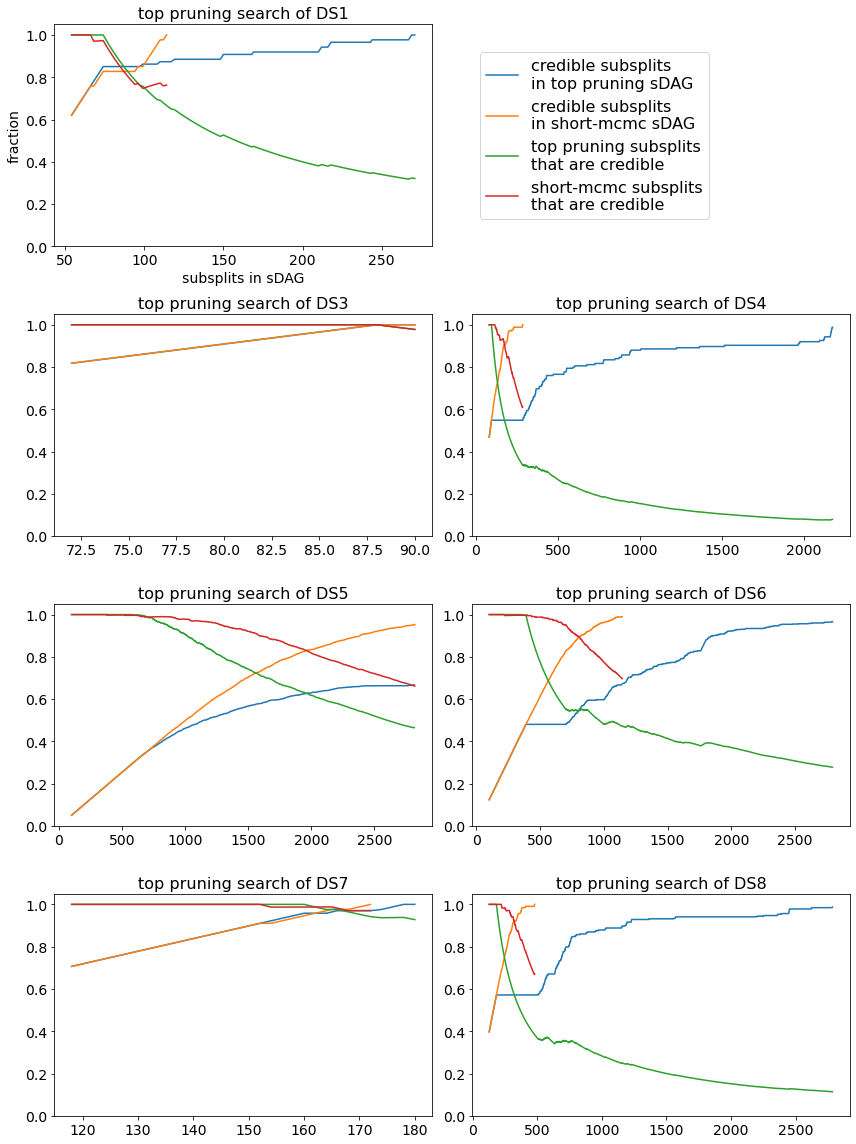

In [6]:
def article_plot_subsplit_credibility():
    ds_list = [1, 3, 4, 5, 6, 7, 8]
    fig, axes = plt.subplots(nrows=4, ncols=2)
    fig.set_figwidth(2*fig.get_figwidth())
    fig.set_figheight(4*fig.get_figheight())
    legend_axes = axes[0][1]
    axes = [axes[i][j] for i in range(4) for j in range(2) if (i,j)!=(0,1) ]
    search_type = "top-pruning"
    prior = "uniform"
    search_col = "cred_node_count" 
    search_total = "node_count" 
    mcmc_col = "sdag_nodes_in_credible"
    mcmc_total = "sdag_node_count" 
    dag_label1 = f"top pruning sDAG"
    mcmc_label1 = "short-mcmc sDAG"
    dag_label2 = f"top pruning"
    mcmc_label2 = "short-mcmc"    
    
    for ds, ax in zip(ds_list, axes):
        search_df = ds_search_results_dataframes[(ds, prior, search_type)]      
        mcmc_df = ds_short_mcmc_dataframes[(ds, prior)]
        post_subsplit_count, cred_subsplit_count = [*posterior_subsplit_stats_dict[(ds,prior)].values()]
        total_count = cred_subsplit_count
        
        fig_title = f"top pruning search of DS{ds}"        
        
        search_cutoff = 1 + search_df[search_col].argmax()
        mcmc_cutoff = 1 + mcmc_df[mcmc_col].argmax()        
        search_view = search_df.loc[:search_cutoff]
        mcmc_view = mcmc_df.loc[:mcmc_cutoff]       
                    
        ax.plot(search_view[search_total], search_view[search_col] / total_count)
        ax.plot(mcmc_view[mcmc_total], mcmc_view[mcmc_col] / total_count)
        ax.plot(search_view[search_total], search_view[search_col] / search_view[search_total])
        ax.plot(mcmc_view[mcmc_total], mcmc_view[mcmc_col] / mcmc_view[mcmc_total])
        if ds==1:
            ax.set_ylabel("fraction", fontsize=14)
            ax.set_xlabel(f"subsplits in sDAG", fontsize=14)
        ax.set_ylim(bottom=0.0,top=1.05)
        ax.set_title(fig_title, fontsize=16)
        ax.tick_params(labelsize=14)
        
    legend_axes.axis("off")
    legend_axes.plot([0], [0], label=f"credible subsplits\nin {dag_label1}")
    legend_axes.plot([0], [0], label=f"credible subsplits\nin {mcmc_label1}")
    legend_axes.plot([0], [0], label=f"{dag_label2} subsplits\nthat are credible")
    legend_axes.plot([0], [0], label=f"{mcmc_label2} subsplits\nthat are credible")        
    legend_axes.legend(loc="center left", fontsize=16)
    fig.tight_layout()
    plt.show()

article_plot_subsplit_credibility()

In [7]:
def article_plot_posterior_densities(page_break_after_ds=4):
    
    ds_list = [1, 3, 4, 5, 6, 7, 8]
    
    thing = {
        1: (1, 6, [1,3]),
        3: (2, 5, [1,4]),
        4: (3, 4, [1,5]),
        5: (4, 3, [1,6]),
        6: (5, 2, [1,7]),
        7: (6, 1, [1,8]),
        8: (7, 0, [1])
    }
    nrows1 = thing[page_break_after_ds][0]
    nrows2 = thing[page_break_after_ds][1]
    ds_with_labels = thing[page_break_after_ds][2]
    
    fig1, axes1 = plt.subplots(nrows=nrows1, ncols=2)
    fig1.set_figwidth(2*fig1.get_figwidth())
    if nrows1 > 1:
        fig1.set_figheight((nrows1+0.25)*fig1.get_figheight())
        fig1.subplots_adjust(hspace=0.35)
    if nrows2 != 0:
        fig2, axes2 = plt.subplots(nrows=nrows2, ncols=2)
        fig2.set_figwidth(2*fig2.get_figwidth())
        fig2.set_figheight(nrows2*fig2.get_figheight())
        if nrows2 > 1:
            fig2.subplots_adjust(hspace=0.35)
            
    if nrows1 == 1:
        axes = [(axes1[0], axes1[1])]
    else:
        axes = [(axes1[i][0], axes1[i][1]) for i in range(nrows1)]
    if nrows2 == 1:
        axes.append((axes2[0], axes2[1]))    
    else: 
        axes.extend(((axes2[i][0], axes2[i][1]) for i in range(nrows2)))
        
        
    search = "top-pruning"
    prior = "uniform"
    dag_label = f"top pruning sDAG"
    iter_label = f"top pruning iteration"
    
    for ds, (ax1, ax2) in zip(ds_list, axes):
        search_df = ds_search_results_dataframes[(ds, prior, search)]      
        mcmc_df = ds_short_mcmc_dataframes[(ds, prior)]
        max_posterior_iter = search_df.tree_pp.argmax()
        max_credible_iter = search_df.cred_tree_count.argmax()
        fig_title = f"{' '*70}top pruning search of DS{ds}"

        ax1.plot(search_df.iter, search_df.tree_pp)
        ax1.scatter(search_df.iter.iat[max_posterior_iter], search_df.tree_pp.iat[max_posterior_iter], 
            s=20, label="last found posterior tree")
        ax1.scatter(search_df.iter.iat[max_credible_iter], search_df.tree_pp.iat[max_credible_iter], 
            color="r", s=20, label="last found credible tree")
        ax1.set_ylim(top=1.05)
        ax1.set_title(fig_title, fontsize=16)
        ax1.tick_params(labelsize=14)
        
        tp_index_to_99 = search_df[search_df.tree_pp < 0.99].iter.max()+1
        tp_time_to_99 = search_df[search_df.iter <= tp_index_to_99].time.max()
        mcmc_index_to_99 = mcmc_df[mcmc_df.total_pp < 0.99].mcmc_iters.max()+1
        mcmc_time_to_99 = mcmc_df[mcmc_df.mcmc_iters <= mcmc_index_to_99].time.max()
        mcmc_index_to_sdag_99 = mcmc_df[mcmc_df.sdag_total_pp < 0.99].mcmc_iters.max()+1
        mcmc_time_to_sdag_99 = mcmc_df[mcmc_df.mcmc_iters <= mcmc_index_to_sdag_99].sdag_total_time.max()
                
        time_cutoff = max(tp_time_to_99, mcmc_time_to_99, mcmc_time_to_sdag_99) 
        search_df = search_df[search_df.time <= time_cutoff]
        mcmc_df = mcmc_df[mcmc_df.time <= time_cutoff]
        mcmc_sdag_df = mcmc_df[mcmc_df.sdag_total_time <= time_cutoff]
    
    
        ax2.plot(search_df.time, search_df.tree_pp, label=dag_label)
        ax2.plot(mcmc_df.time, mcmc_df.total_pp, label="short run of Mr. Bayes")
        ax2.plot(mcmc_sdag_df.sdag_total_time, mcmc_sdag_df.sdag_total_pp, alpha=0.5,
            label="sdag spanned by short\nrun of Mr. Bayes")
        ax2.set_ylim(top=1.03)
        ax2.tick_params(labelsize=14)

        
        if ds in ds_with_labels:
            ax1.set_xlabel(iter_label, fontsize=14)
            ax1.set_ylabel("cumulative density of trees\n in search sDAG", fontsize=14)    
            ax1.legend(fontsize=16)
            ax2.set_xlabel("approximate run-time (seconds)", fontsize=14)
            ax2.legend(fontsize=16)
        
    plt.show()

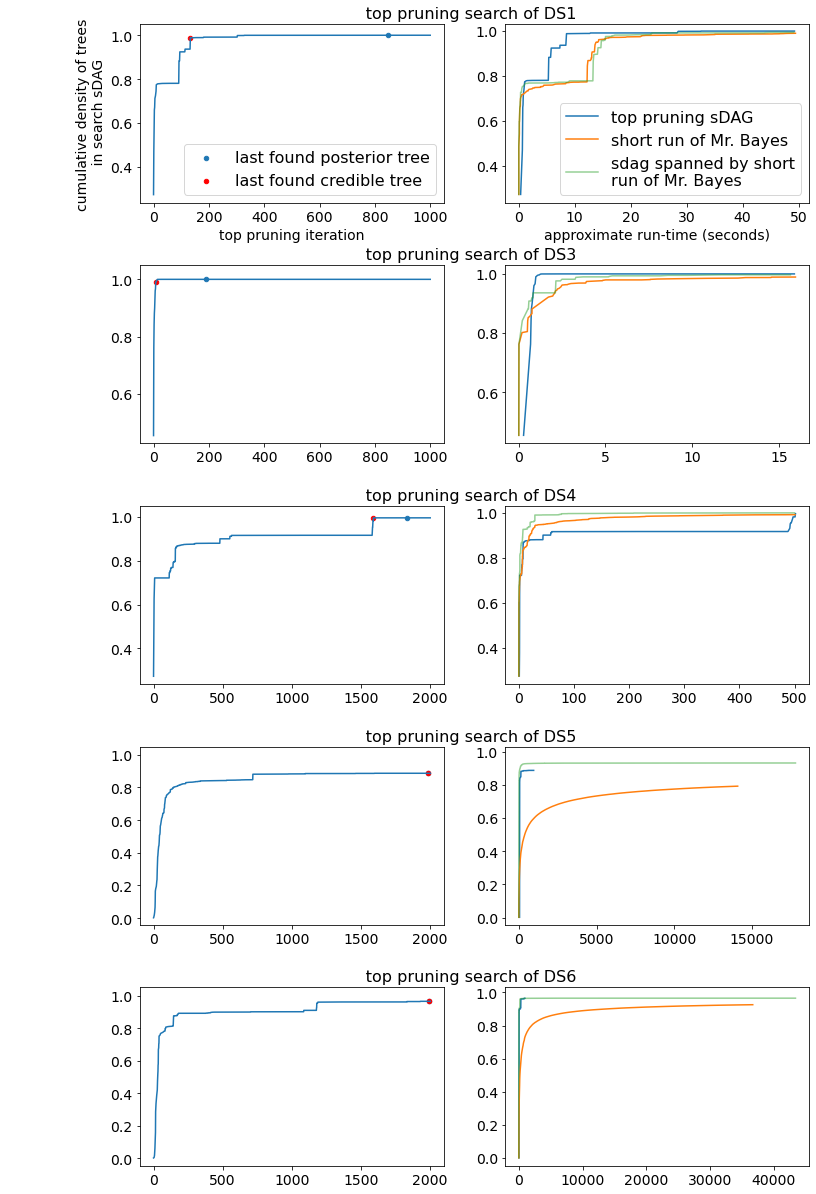

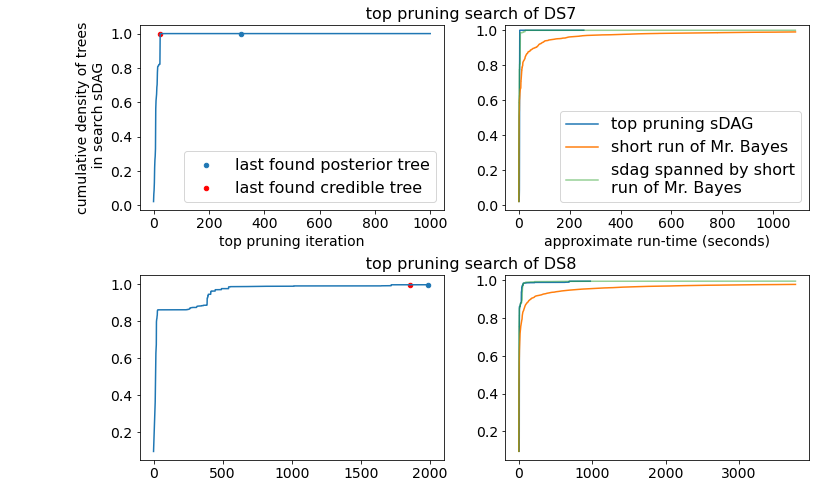

In [16]:
article_plot_posterior_densities(page_break_after_ds=6)

In [8]:
def article_plot_flu_data():
    # Load all data files into dataframes.
    mb_avg_gen_run_time = 69/100000
    processing_mb_avg_gen_run_time = 132/1000000

    search_results_path = "data/flu100/_output/flu100.results.tp.2000.csv"
    short_mcmc_stats_path = "data/flu100/_output/short_mcmc/mcmc_search_sdag_stats.csv"
    search_time_path = search_results_path[:-4] + ".time.csv"

    results_df = pd.read_csv(search_results_path)
    results_df.drop_duplicates(subset="iter", keep="first", inplace=True)
    time_df = pd.read_csv(search_time_path)
    results_df = results_df.merge(time_df, on="iter")
    short_mcmc_df = pd.read_csv(short_mcmc_stats_path)
    short_mcmc_df["time"] = mb_avg_gen_run_time*short_mcmc_df.mcmc_iters            
    iter_time = mb_avg_gen_run_time + processing_mb_avg_gen_run_time
    short_mcmc_df["sdag_total_time"] = short_mcmc_df.sdag_build_time + iter_time*short_mcmc_df.mcmc_iters        
    
    search_df = results_df      
    mcmc_df = short_mcmc_df
    
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows=2,ncols=2)
    fig.set_figheight(2.75*fig.get_figheight())
    fig.set_figwidth(2.25*fig.get_figwidth())

    
    search = "top-pruning"
    prior = "uniform"
    dag_label = f"top pruning sDAG"
    iter_label = f"top pruning iteration"
    
    max_posterior_iter = search_df.tree_pp.argmax()
    max_credible_iter = search_df.cred_tree_count.argmax()
    fig_title = f"{' '*70}top pruning search of the flu100 dataset"

    ax1.plot(search_df.iter, search_df.tree_pp)
    ax1.scatter(search_df.iter.iat[max_posterior_iter], search_df.tree_pp.iat[max_posterior_iter], 
        s=20, label="last found posterior tree")
    ax1.scatter(search_df.iter.iat[max_credible_iter], search_df.tree_pp.iat[max_credible_iter], 
        color="r", s=20, label="last found credible tree")
    ax1.set_ylim(top=1.05)
    ax1.set_title(fig_title, fontsize=16)
    ax1.tick_params(labelsize=14)
    ax1.set_xlabel(iter_label, fontsize=14)
    ax1.set_ylabel("cumulative density of trees\n in search sDAG", fontsize=14)    
    ax1.legend(fontsize=16)    
    
    tp_index_to_99 = search_df[search_df.tree_pp < 0.99].iter.max()+1
    tp_time_to_99 = search_df[search_df.iter <= tp_index_to_99].time.max()
    mcmc_index_to_99 = mcmc_df[mcmc_df.total_pp < 0.99].mcmc_iters.max()+1
    mcmc_time_to_99 = mcmc_df[mcmc_df.mcmc_iters <= mcmc_index_to_99].time.max()
    
    mcmc_index_to_sdag_99 = mcmc_df[mcmc_df.sdag_total_pp < 0.99].mcmc_iters.max()+1
    mcmc_time_to_sdag_99 = mcmc_df[mcmc_df.mcmc_iters <= mcmc_index_to_sdag_99].sdag_total_time.max()
    time_cutoff = max(tp_time_to_99, mcmc_time_to_99, mcmc_time_to_sdag_99) 
    search_df = search_df[search_df.time <= time_cutoff]
    mcmc_df = mcmc_df[mcmc_df.time <= time_cutoff]
    mcmc_sdag_df = mcmc_df[mcmc_df.sdag_total_time <= time_cutoff]
    
    ax2.plot(search_df.time, search_df.tree_pp, label=dag_label)
    ax2.plot(mcmc_df.time, mcmc_df.total_pp, label="short run of Mr. Bayes")
    ax2.plot(mcmc_sdag_df.sdag_total_time, mcmc_sdag_df.sdag_total_pp, alpha=0.5,
       label="sdag spanned by short\nrun of Mr. Bayes")
    ax2.set_ylim(top=1.03)
    ax2.tick_params(labelsize=14)
    ax2.set_xlabel("approximate run-time (seconds)", fontsize=14)
    ax2.legend(fontsize=16)
        

    search_type = "top-pruning"
    prior = "uniform"
    search_col = "cred_node_count" 
    search_total = "node_count" 
    mcmc_col = "sdag_nodes_in_credible"
    mcmc_total = "sdag_node_count" 
    dag_label1 = f"top pruning sDAG"
    mcmc_label1 = "short-mcmc sDAG"
    dag_label2 = f"top pruning"
    mcmc_label2 = "short-mcmc"    
    
        
    search_df = results_df      
    mcmc_df = short_mcmc_df
    post_subsplit_count, cred_subsplit_count = 656, 599 #should instead grab from file...
    total_count = cred_subsplit_count
                        
    search_cutoff = 1 + search_df[search_col].argmax()
    mcmc_cutoff = 1 + mcmc_df[mcmc_col].argmax()        
    search_view = search_df.loc[:search_cutoff]
    mcmc_view = mcmc_df.loc[:mcmc_cutoff]       
        
    ax3.plot(search_view[search_total], search_view[search_col] / total_count,
        label=f"credible subsplits\nin {dag_label1}" )
    ax3.plot(mcmc_view[mcmc_total], mcmc_view[mcmc_col] / total_count,
        label=f"credible subsplits\nin {mcmc_label1}" )
    ax3.plot(search_view[search_total], search_view[search_col] / search_view[search_total],
        label=f"{dag_label2} subsplits\nthat are credible" )
    ax3.plot(mcmc_view[mcmc_total], mcmc_view[mcmc_col] / mcmc_view[mcmc_total],
        label=f"{mcmc_label2} subsplits\nthat are credible")        
    ax3.set_ylabel("fraction", fontsize=14)
    ax3.set_xlabel(f"subsplits in sDAG", fontsize=14)
    ax3.set_ylim(bottom=0.0,top=1.05)
    ax3.tick_params(labelsize=14)
    ax3.legend(fontsize=16, loc="lower center")    
    
    single_tree_start = results_df[results_df.iter <= 300]      
    multiple_tree_start = pd.read_csv(f"data/flu100/_output/flu100.results.tp.300.top10.csv")
    raxml_trees_start = pd.read_csv(f"data/flu100/_output/flu100.results.tp.300.top_raxml.csv")    
    ax4.plot(single_tree_start.iter, single_tree_start.tree_pp, label="single starting tree")
    ax4.plot(multiple_tree_start.iter, multiple_tree_start.tree_pp, label=f"top 10 credible starting trees")    
    ax4.plot(raxml_trees_start.iter, raxml_trees_start.tree_pp, label=f"raxml starting trees")
    ax4.set_xlabel("top pruning iteration", fontsize=14)
    ax4.set_ylabel("cumulative density of trees\n in search sDAG", fontsize=14)
    ax4.tick_params(labelsize=14)
    ax4.set_ylim(bottom=0.0,top=1.05)
    ax4.legend(fontsize=16)    
    
    fig.subplots_adjust(hspace=0.25)
    fig.subplots_adjust(wspace=0.25)
    plt.show()

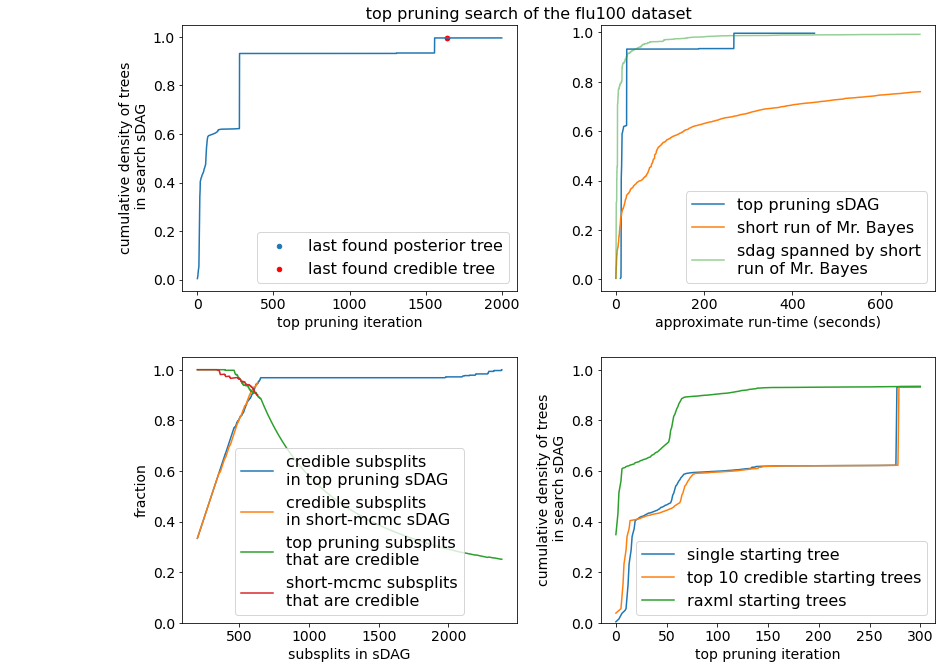

In [12]:
article_plot_flu_data()